# CS 171 Problem Set 2 (all questions)

The loss function for logistic regression, $f(x) = \sigma(x^\top w)$, is
\begin{align*}
l(y,\hat{y}) &= -\ln \sigma(y\hat{y}) \\
\text{and thus} \\
L &= \frac{1}{m}\sum_{i=1}^m -\ln \sigma(y_i f(x_i))
\end{align*}
In class, we derived that the resulting gradient was, therefore,
\begin{align*}
\nabla_w L &= \frac{-1}{m}\sum_{i=1}^m (1-p_i)y_ix_i \\
\text{where} \\
p_i &= \sigma(y_i w^\top x_i)
\end{align*}
And so the update rule for $w$ is
\begin{align*}
w &\leftarrow w + \eta \frac{1}{m}\sum_{i=1}^m (1-p_i)y_ix_i 
\end{align*}

<div class="alert alert-info"><font size=5>Problem 1 (5 pts)</font>

Modify the total loss function, $L$, to include a regularization term with strength $\lambda/m$ that penalizes the sum of the squares of the weights.

***Write the new loss function.  Derive the gradient descent rule for this new loss function.***

### Your Answer Here 
The loss function with regularization is
\begin{align}
L=\frac{1}{m}\sum_{i=1}^m-\ln\sigma(y_if(x_i))+\frac{\lambda}{m}\sum_{j=1}^nw_j^2
\end{align}
The gradient is
\begin{align}
\nabla_wL=\frac{-1}{m}\sum_{i=1}^m(1-p_i)y_ix_i+\frac{2\lambda}{m}w
\end{align}
where
\begin{align}
p_i=\sigma(y_iw^\top x_i)
\end{align}
Therefore, the gradient descent rule for this new loss function is
\begin{align}
w\leftarrow w-\eta(-\frac{1}{m}\sum_{i=1}^m(1-\sigma(y_iw^\top x_i))y_ix_i+\frac{2\lambda}{m}w).
\end{align}

<div class="alert, alert-info"><font size=5>Problem 2 (10 pts)</font>

***Write a function `learnlogreg` that uses your gradent descent rule from Problem 1.***

- As a stopping condition, stop when the _square_ of the _length_ of the gradient (as a vector) falls below $10^{-10}$.
- Assume that the first feature of `X` (the first column) is all 1s and that no regularization should be applied to it.
- Do (batch) gradient descent, not stochastic gradient descent
- Selecting the step size can be tricky.  Professional versions use adaptive methods to vary the step size from iteration to iteration.  However, for this assignment, use a constant step size for all iterations.  From experimentation, setting the stepsize as $\eta = \sqrt{\frac{2.5}{\lambda}}$ works.  This is weird, but it will allow for quick convergence for the $\lambda$ values we will use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# load the data
def loadsparsedata(fn):
    
    fp = open(fn,"r")
    lines = fp.readlines()
    maxf = 0;
    for line in lines:
        for i in line.split()[1::2]:
            maxf = max(maxf,int(i))
    
    X = np.zeros((len(lines),maxf))
    Y = np.zeros((len(lines)))
    
    for i, line in enumerate(lines):
        values = line.split()
        Y[i] = int(values[0])
        for j,v in zip(values[1::2],values[2::2]):
            X[i,int(j)-1] = int(v)
    
    return X,Y

In [2]:
from IPython.display import display, clear_output

def learnlogreg(X,Y01,lam):
    # X is an np.array of shape (m,n) with the first column all 1s
    # Y01 is an np.array of shape (m,1) with element either 0 or 1
    # lam is the regularization strength (a scalar)
    
    Y = Y01.copy() # rules derived in class assume that 
    Y[Y==0] = -1 # the classes are represented by +1 and -1, not +1, and 0
    (m,n) = X.shape

    w = np.zeros((n))
    
    eta = np.sqrt(2.5/lam) # the suggested stepsize (see above)
    
    ### YOUR CODE HERE
    nX = np.mat(X).T
    mXY = -np.multiply(nX,Y)
    c1 = 2*lam/m
    while 1:
        #calculate pi = σ(yiwTxi)
        pi = 1.0/(1.0+np.exp(w@mXY))
        #calculate gi = -(1-pi)yixi
        gi = np.multiply((1.0-pi),mXY).T
        g = np.squeeze(((gi.sum(axis = 0))*(1/m)).tolist(),axis = 0)+w*c1
        #add regularization, and not apply to first column
        g[0] -= w[0]*c1
        w -= g*eta
        if g@g<1e-10:
            break
    
    return w

In [3]:
(trainX,trainY) = loadsparsedata("spamtrain.txt")
trainX = np.column_stack((np.ones(trainX.shape[0]),trainX)) # add column of 1s as zeroth feature

w = learnlogreg(trainX,trainY,1e-3) # just an example to check with lambda=0.001

In [4]:
def linearerror(X,Y,w):
    # returns error *rate* for linear classifier with coefficients w
    m = Y.shape[0]
    predy = X.dot(w)
    err = (Y[predy>=0]<0.5).sum() + (Y[predy<0]>=0.5).sum()
    return err/m

linearerror(trainX,trainY,w) # should be 0.001333... (if lambda=0.001, above)

0.0013333333333333333

<div class="alert, alert-info"><font size=5>Problem 3 (10 pts)</font>

***Plot a comparison of the cross-validation estimate of the error rate with the testing error rate, as a function of $\lambda$***

Use _5-fold cross validation_ for each of the $\lambda$ values (as shown below).  Plot the cross-validation error estimate as a function of $\lambda$.

Then use the entire training set to train a model (for each $\lambda$) and plot (on the same graph) the _testing_ error rate as a function of $\lambda$

- For the plots, use `plt.semilogx` (instead of `plt.plot`)
- Label your axes and plot (use `plt.xlabel`, `plt.ylabel` and `plt.legend`)
- It may take a while (10 minutes) to train all of the models
- Use the $\lambda$ values defined below as `lambdas`

To keep grading simple, do ***not*** scramble the data.  Instead, divide into consequtive fifths, without reordering (see the `split` function in `numpy`).

Note, this will probably take about 5 minutes to complete.  

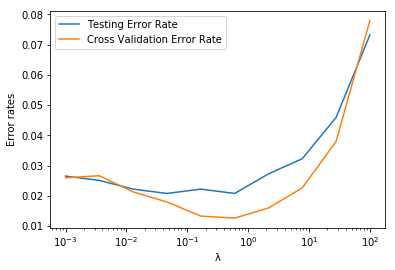

In [5]:
lambdas = np.logspace(-3,2,10)

### Your Code Here
#import data
(trainX,trainY) = loadsparsedata("spamtrain.txt")
trainX = np.column_stack((np.ones(trainX.shape[0]),trainX))
ntrainX = np.array_split(trainX,5,0)
ntrainY = np.array_split(trainY,5,0)
(testX,testY) = loadsparsedata("spamtest.txt")
testX = np.column_stack((np.ones(testX.shape[0]),testX))

#calculate the error rate when nth fold is the validation set
def nfold(X,Y,lambdas,n):
    testX = X[n-1]
    testY = Y[n-1]
    X = np.delete(X,n-1,axis = 0)
    X = np.concatenate((X[0],X[1],X[2],X[3]),axis = 0)
    Y = np.delete(Y,n-1,axis = 0)
    Y = np.concatenate((Y[0],Y[1],Y[2],Y[3]),axis = 0)
    error = np.zeros((10))
    for i in range(10):
        error[i] = linearerror(testX,testY,learnlogreg(X,Y,lambdas[i]))
    return error

#calculate error rate for cross validation and regular training
crossrate = np.zeros((5,10))
for n in range(5):
    crossrate[n] = nfold(ntrainX,ntrainY,lambdas,n+1)
crossrate = np.mat(crossrate).T
avgcross = np.mean(crossrate, axis=1)
allrate = np.zeros((10))
for n in range(10):
    allrate[n] = linearerror(testX,testY,learnlogreg(trainX,trainY,lambdas[n]))
    
#plot data
plt.semilogx(lambdas,allrate,label = 'Testing Error Rate')
plt.semilogx(lambdas,avgcross,label = 'Cross Validation Error Rate')
plt.xlabel('λ')
plt.ylabel('Error rates')
plt.legend()
plt.show()